This Notebook is for analyzing the city-data Dataset.
We start by importing the neccessary libraries.

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import mplcursors

reading the Dataset

In [3]:
data = pd.read_csv('../city_data.csv', delimiter='|')

Preprocessing the dataset:

Adjusting the columns,
Splitting the city-country column into two seperate columns for better readability, 
removing a column with two many missing values,
and removing duplicate rows.


In [4]:
new_header = data.iloc[0]
data = data[1:]
data.columns = new_header

cities = []
states = []
for i in range(len(data)):
    if ',' in data.iloc[i]["City"]:
        city_and_state = data.iloc[i]["City"].split(",")
    elif '.' in data.iloc[i]["City"]:
        city_and_state = data.iloc[i]["City"].split(".")
    else:
        city_and_state = data.iloc[i]["City"].split(";")
         
    cities.append(city_and_state[0])
    if len(city_and_state) > 1:
        states.append(city_and_state[1])
    else:
        states.append("")

data.drop(columns=['City'], inplace=True)
data.insert(0, 'City', cities)
data.insert(1, 'Country', states)

data.drop(columns=['Average Price Groceries'], inplace=True)

data.drop_duplicates(inplace=True)

Changing the dtype of numeric columns

In [5]:
for col in data.columns:
    try:
        data[col] = pd.to_numeric(data[col])
    except:
        pass  # keep text columns (City, Country) as is

Apply Knn Imputation for replacing missing values in the dataset

In [6]:
numeric_cols = data.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
scaled = scaler.fit_transform(data[numeric_cols])

imputer = KNNImputer(n_neighbors=7)
imputed_scaled = imputer.fit_transform(scaled)

# Inverse scale back
imputed = scaler.inverse_transform(imputed_scaled)

# Put back into DataFrame
data[numeric_cols] = imputed

Data about quantity of cities

In [7]:
cities_count_ser = data.groupby('Country')['City'].count().sort_values(ascending=False)
amount_of_cities = pd.DataFrame({"Number of Cities": cities_count_ser})
total_number_of_cities = amount_of_cities['Number of Cities'].sum()
print("\nCities Summery:\n")
print(amount_of_cities)
print(f"\nAmount of Cities in total: {total_number_of_cities}\n")


Cities Summery:

                  Number of Cities
Country                           
 Germany                        10
 Italy                           6
 United Kingdom                  5
 Netherlands                     5
 Spain                           5
 Portugal                        4
 Belgium                         4
 Poland                          3
 Norway                          3
 Sweden                          3
 Hungary                         3
 Switzerland                     3
 France                          2
 Finland                         2
 Ireland                         2
 Turkiye                         2
 Denmark                         2
 Czechia                         2
 Croatia                         2
 Bulgaria                        2
 Austria                         2
 Romania                         1
 Slovenia                        1
 Slovak Republic                 1
  France                         1
 Malta                           1
 L

Cities with the highest salary

In [7]:
print("\nHigh Salary Cities:\n")
print(data[data["Average Monthly Salary"] > 1600].sort_values(by='Average Monthly Salary', ascending=False)[["City", "Average Monthly Salary"]])


High Salary Cities:

0                City  Average Monthly Salary
9              Zurich                  6636.0
11              Basel                  6366.0
10             Geneva                  5794.0
27         Copenhagen                  4200.0
61         Luxembourg                  4200.0
36           Helsinki                  3900.0
21  Frankfurt am Main                  3800.0
65          Amsterdam                  3750.0
69               Oslo                  3600.0
19             Munich                  3540.0
64          The Hague                  3500.0
37            Tampere                  3500.0
70             Bergen                  3500.0
18            Hamburg                  3500.0
71          Stavanger                  3500.0
28             Odense                  3400.0
3            Brussels                  3350.0
38              Paris                  3300.0
22          Stuttgart                  3300.0
20            Cologne                  3200.0
2           

Cities with low cost of living

In [8]:
print("\nLow Cost of living:\n")
print(data[data["Average Cost of Living"] < 900].sort_values(by="Average Cost of Living", ascending=False)[["City", "Average Cost of Living"]])


Low Cost of living:

0    City  Average Cost of Living
86  Adana                   800.0


Highest difference between salary and cost of living

In [9]:
data["avg salary - avg cost of living"] = data["Average Monthly Salary"] - data["Average Cost of Living"]
print("\nDifference between cost of living and salary:\n")
print(data[['City', "avg salary - avg cost of living"]].sort_values(by='avg salary - avg cost of living', ascending=False).head(5))


Difference between cost of living and salary:

0       City  avg salary - avg cost of living
11     Basel                           2127.0
37   Tampere                           1900.0
36  Helsinki                           1850.0
9     Zurich                           1774.0
10    Geneva                           1531.0


Correlation between salary and cost of living

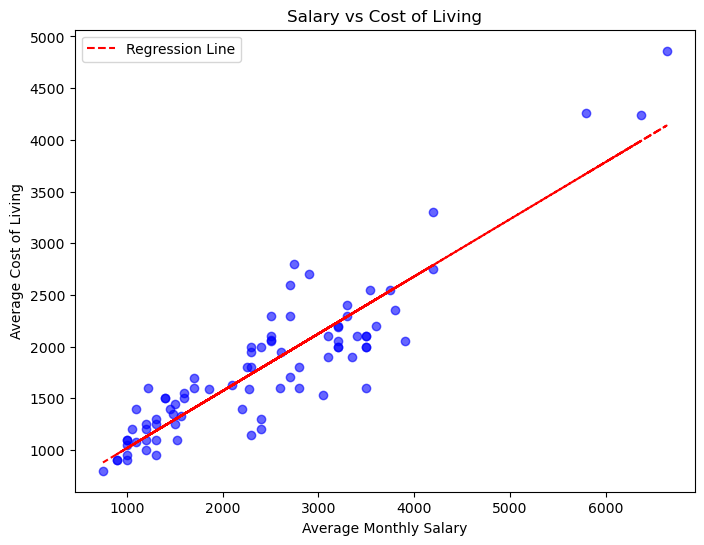

In [8]:
# Prepare data
x = data["Average Monthly Salary"].values.reshape(-1, 1)
y = data["Average Cost of Living"].values

# Fit linear regression
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

# Close any existing figures (prevents leftover lines from previous interactive runs)
plt.close('all')

# Scatter plot
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(x, y, c='blue', alpha=0.6)

# Regression line
ax.plot(x, y_pred, color='red', linestyle='--', label='Regression Line')


ax.set_xlabel("Average Monthly Salary")
ax.set_ylabel("Average Cost of Living")
ax.set_title("Salary vs Cost of Living")
ax.legend()

# Make points clickable to show city
cursor = mplcursors.cursor(sc, hover=True)
@cursor.connect("add")
def on_add(sel):
    index = sel.index
    sel.annotation.set(text=data.iloc[index]["City"])

plt.show()

The most spoken languages

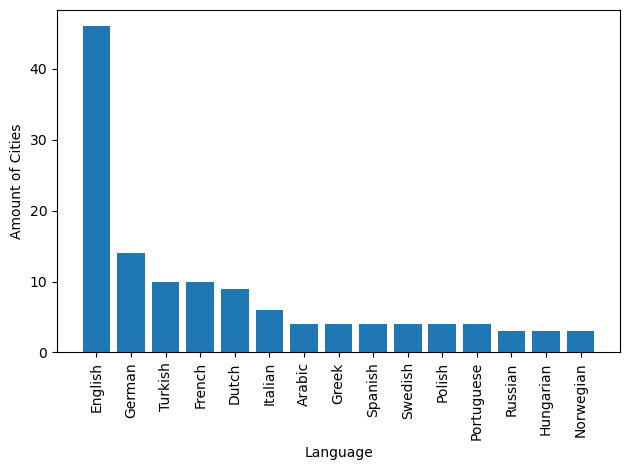

In [9]:
languages = {}
english_spoken = []
for item in data['Main Spoken Languages']:
    lst = str(item).split(",")
    eng = False
    for i in lst:
        i = i.strip()
        if i == 'English':
            eng = True
        if i not in languages:
            languages[i] = 1
        else:
            languages[i] += 1
    english_spoken.append(eng)

data['english_spoken'] = english_spoken

languages = sorted(languages.items(), key=lambda x: x[1], reverse=True)

spoken_languages, counts = map(list, zip(*languages))

plt.bar(x=spoken_languages[:15], height=counts[:15])
plt.xticks(rotation=90)
plt.xlabel('Language')
plt.ylabel('Amount of Cities')
plt.tight_layout()
plt.show()

Cities with the most poeple unemployed:

In [10]:
data['unemployed_amt'] = data['Working Age Population '] * (data['Unemployment Rate'] / 100)
data['unemployed_amt'] = data['unemployed_amt'].astype(np.int64)

print("\nCities with the most people unemployed:\n")
print(data[['City', 'unemployed_amt']]\
      .sort_values(by='unemployed_amt', ascending=False).head().set_index('City'))


Cities with the most people unemployed:

0       unemployed_amt
City                  
Naples          519495
London          504762
Madrid          498717
Ankara          492147
Greece          393393


Comparing English speaking cities with Non-English speaking cities

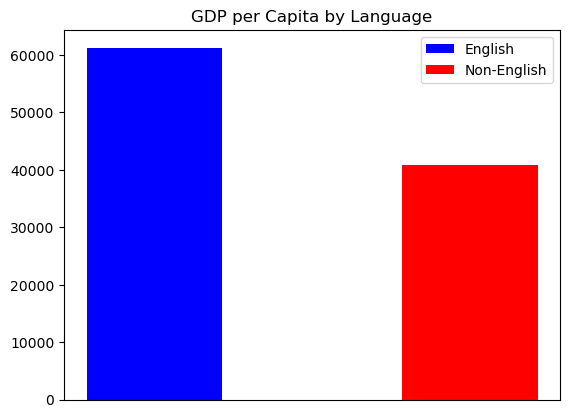

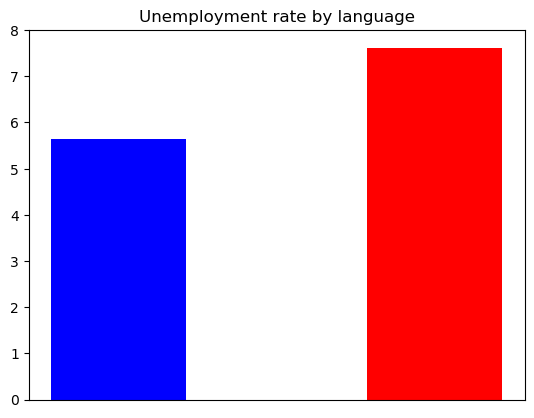

In [16]:
english_speaking_cities = data[data['english_spoken'] == True]
non_english_speaking_cities = data[data['english_spoken'] == False]

gdp_eng = english_speaking_cities['GDP per Capita'].mean()
gdp_non_eng = non_english_speaking_cities['GDP per Capita'].mean()

unemployment_eng = english_speaking_cities['Unemployment Rate'].mean()
unemployment_non_eng = non_english_speaking_cities['Unemployment Rate'].mean()

fig, ax = plt.subplots()

x = np.array([0])

ax.bar(x - 0.35/2, [gdp_eng], 0.15, label='English', color='blue')
ax.bar(x + 0.35/2, [gdp_non_eng], 0.15, label='Non-English', color='red')
ax.set_title('GDP per Capita by Language')
ax.set_xticks([])
ax.legend()

fig2, ax2 = plt.subplots()
ax2.bar(x - 0.35/2, unemployment_eng, 0.15, label='English', color='blue')
ax2.bar(x + 0.35/2, unemployment_non_eng, 0.15, label='Non-English', color='red')
ax2.set_title('Unemployment rate by language')
ax2.set_xticks([])
ax.legend()

plt.show()